In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from jax import jit, vmap
import jaxquantum as jqt
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

# Time Independent

In [17]:
H = jqt.destroy(10) + jqt.create(10)
ts = 0.0# jnp.linspace(0, 10, 101)
Us = jqt.propagator(H, ts)

In [18]:
g_d = 1e-3
N1 = 10
N2 = 2
a = jqt.destroy(N1) ^ jqt.identity(N2)
a_dag = jqt.create(N1) ^ jqt.identity(N2)
Ht = lambda t: t * g_d * (a + a_dag)
ts = 0.0 #jnp.linspace(0, 1000, 101)

Us = jqt.propagator(Ht, ts)

In [19]:
H_x = jqt.sigmax()
ts = jnp.linspace(0.0, 2*jnp.pi, 101)
U_props = jqt.propagator(H_x, ts)
U_props[-1] - jqt.propagator(H_x, ts[-1])

Quantum array: dims = ((2,), (2,)), bdims = (), shape = (2, 2), type = oper
Qarray data =
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

# Time Dependent

In [20]:
omega_q = 5.0 #GHzz
Omega = .1
g_state = jqt.basis(2,0) ^ jqt.basis(2,0)
ts = jnp.linspace(0.0,5*jnp.pi/Omega,101)

sz0 = jqt.sigmaz() ^ jqt.identity(N=2)

@jit
def Ht(t):
    H0 = omega_q/2.0*((jqt.sigmaz()^jqt.identity(N=2)) + (jqt.identity(N=2)^jqt.sigmaz()))
    H1 = Omega*jnp.cos((omega_q)*t)*((jqt.sigmax()^jqt.identity(N=2)) + (jqt.identity(N=2)^jqt.sigmax()))
    return H0 + H1

In [23]:
# baseline to test against
states = jqt.sesolve(Ht, g_state, ts) 
szt = jnp.real(jqt.overlap(sz0, states))

100% |██████████| [00:00<00:00, 1520.47%/s]


In [26]:
# fastest way to calculate propagators for many time points
solver_options = jqt.SolverOptions.create(progress_meter=False)
U_props = jqt.propagator(Ht, ts, solver_options=solver_options)
states_prop = U_props @ g_state 
szt_prop = jnp.real(jqt.overlap(sz0, states_prop))

100% |██████████| [00:00<00:00, 1442.70%/s]


In [38]:
# testing propagators on scalar t, this is much slower
ts_2 = jnp.linspace(0.1, 5*jnp.pi/Omega, 11)
U_props = [jqt.propagator(Ht, t, solver_options=solver_options)[-1] for t in ts_2]
states_prop = jqt.Qarray.from_list([U_prop @ g_state for U_prop in U_props])
szt_prop2 = jnp.real(jqt.overlap(sz0, states_prop))

100% |██████████| [00:00<00:00, 72353.01%/s]
100% |██████████| [00:00<00:00, 13064.74%/s]
100% |██████████| [00:00<00:00, 4896.68%/s]
100% |██████████| [00:00<00:00, 4598.36%/s]
100% |██████████| [00:00<00:00, 3527.47%/s]
100% |██████████| [00:00<00:00, 2800.18%/s]
100% |██████████| [00:00<00:00, 682.69%/s] 
100% |██████████| [00:00<00:00, 847.54%/s]
100% |██████████| [00:00<00:00, 405.01%/s] 
100% |██████████| [00:00<00:00, 1684.58%/s]
100% |██████████| [00:00<00:00, 1596.97%/s]


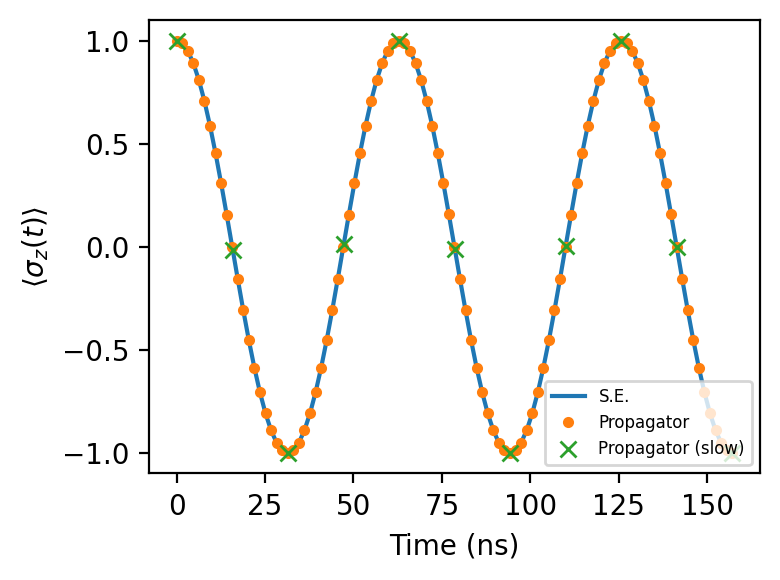

In [39]:
# plotting
fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt, label="S.E.")
ax.plot(ts, szt, ".", label="Propagator")
ax.plot(ts_2, szt_prop2, "x", label="Propagator (slow)")
ax.legend(fontsize=6, loc="lower right")
ax.set_xlabel("Time (ns)")
ax.set_ylabel(r"$\langle\sigma_z(t)\rangle$")
fig.tight_layout()